In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

#read data
df = pd.read_csv("train.csv", low_memory=False)

In [2]:
#target cleaning

df = df[df["Credit_Score"].isin(["Good", "Poor"])].copy()
df["target"] = df["Credit_Score"].map({"Good": 1, "Poor": 0})
df.drop(columns=["Credit_Score"], inplace=True)

In [3]:
#basic cleaning
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df.loc[(df["Age"] < 18) | (df["Age"] > 100), "Age"] = np.nan

num_cols = [
    "Annual_Income", "Monthly_Inhand_Salary", "Outstanding_Debt",
    "Amount_invested_monthly", "Monthly_Balance"
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.drop(columns=["ID", "Customer_ID", "Name", "SSN", "Month"], inplace=True)

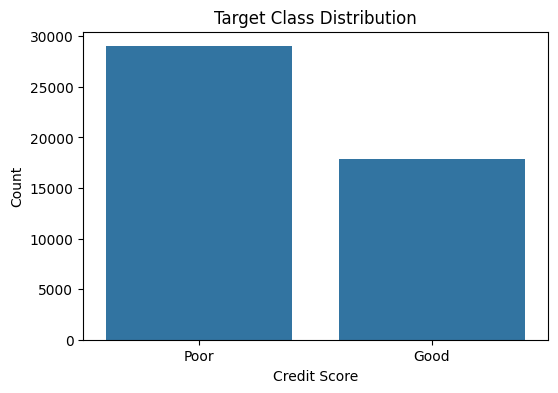

target
0    0.619271
1    0.380729
Name: proportion, dtype: float64


In [4]:
#EDA
#1.Target Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df)
plt.xticks([0,1], ["Poor", "Good"])
plt.title("Target Class Distribution")
plt.ylabel("Count")
plt.xlabel("Credit Score")
plt.show()

print(df["target"].value_counts(normalize=True))

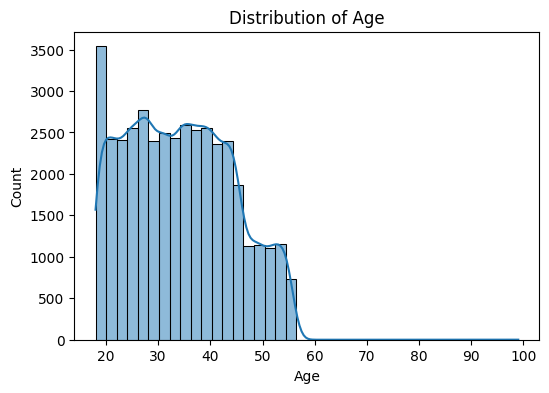

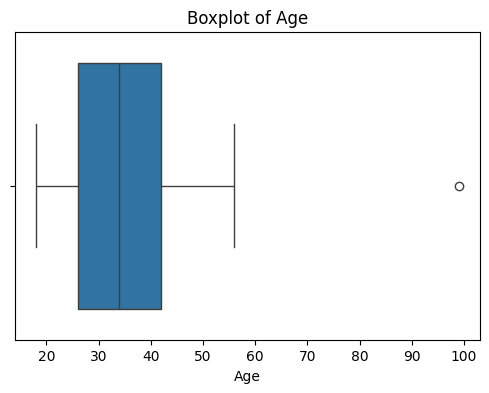

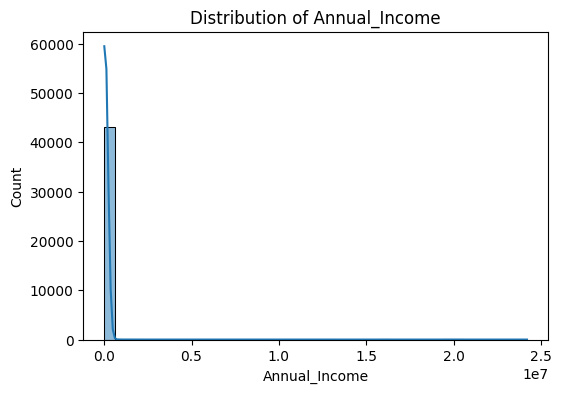

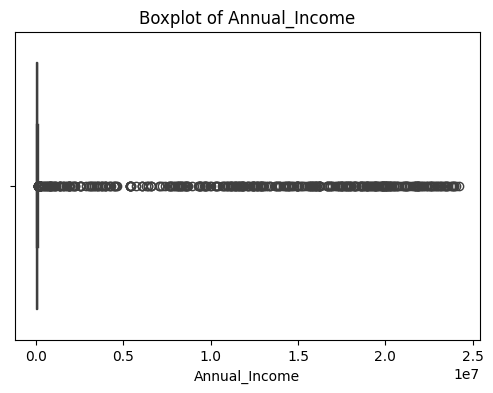

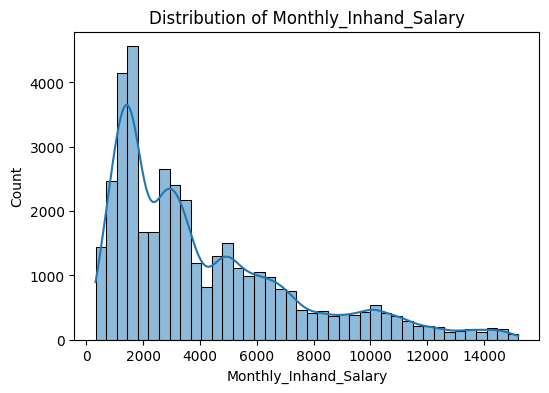

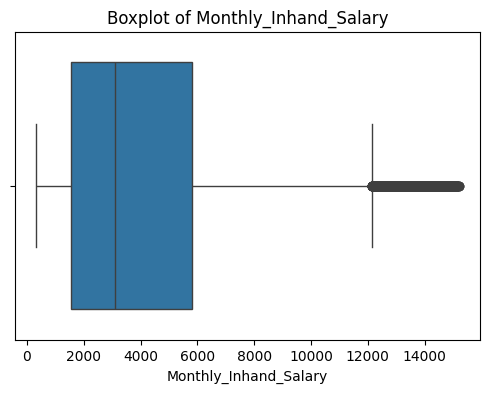

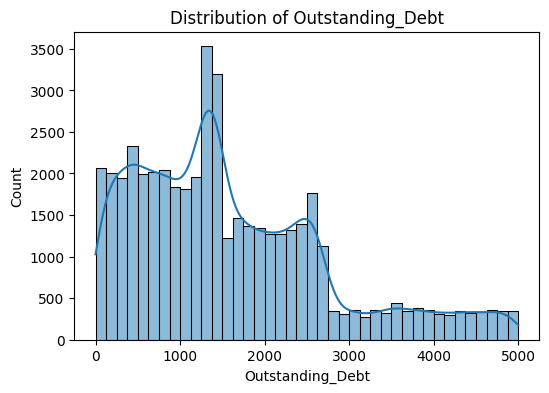

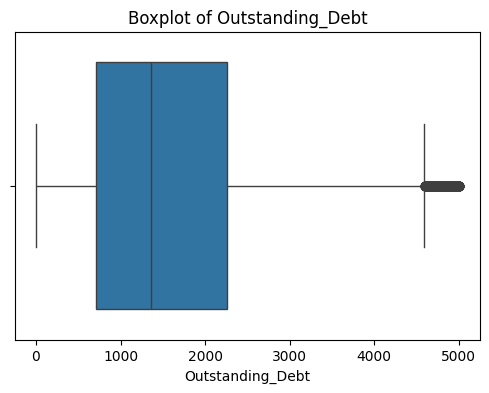

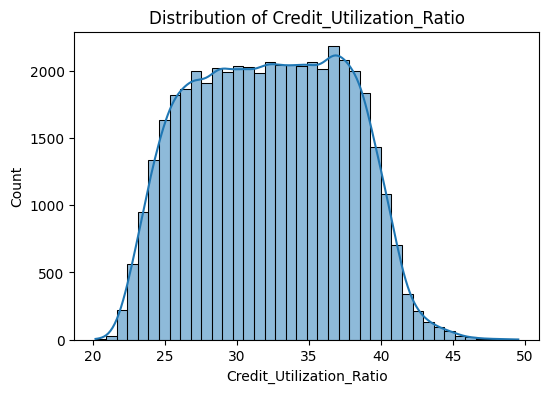

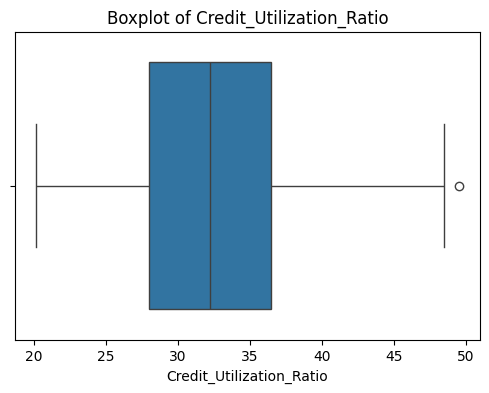

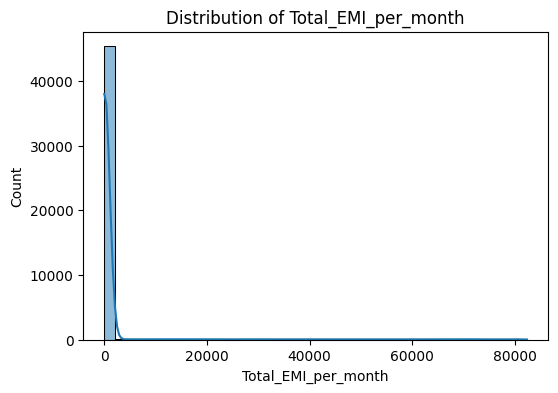

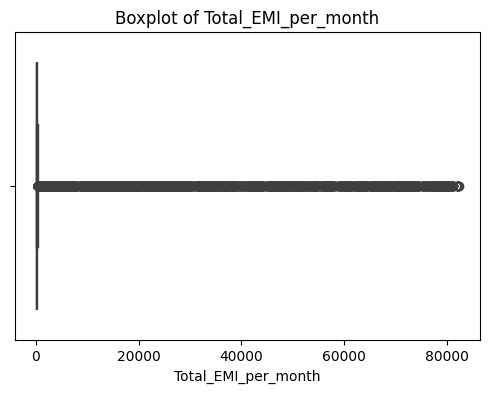

In [5]:
#EDA
#2. Numerical Feature Distributions
num_features = [
    "Age", "Annual_Income", "Monthly_Inhand_Salary",
    "Outstanding_Debt", "Credit_Utilization_Ratio",
    "Total_EMI_per_month"
]

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

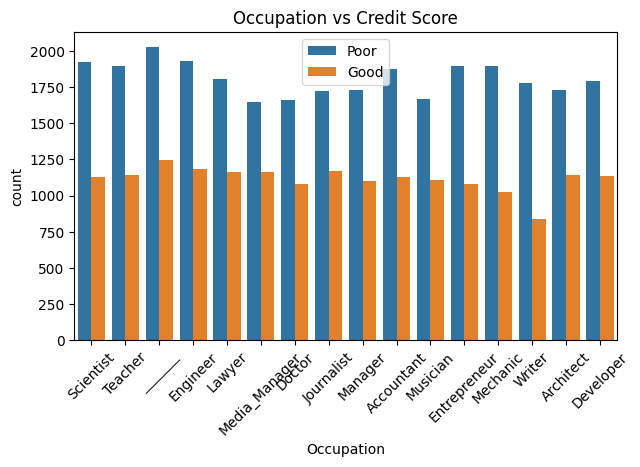

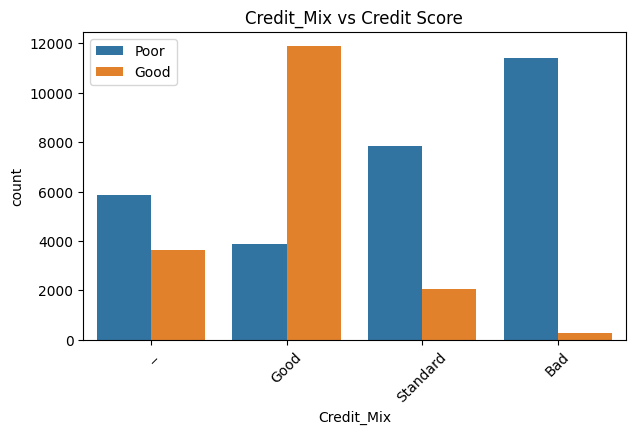

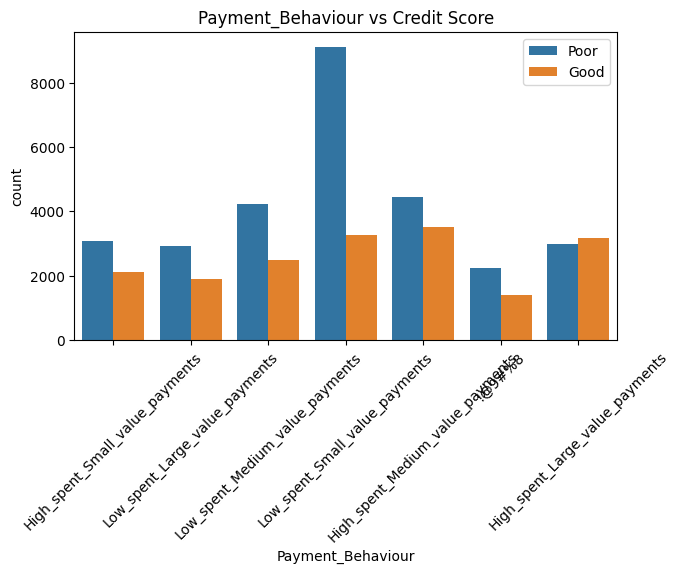

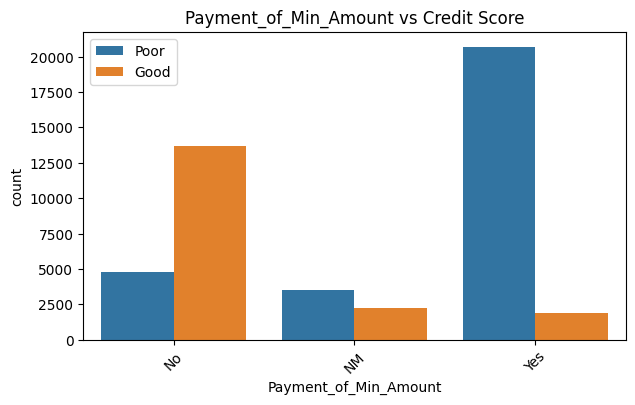

In [6]:
#EDA
#3. Categorical Feature vs Target
cat_features = [
    "Occupation", "Credit_Mix",
    "Payment_Behaviour", "Payment_of_Min_Amount"
]

for col in cat_features:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df, x=col, hue="target")
    plt.title(f"{col} vs Credit Score")
    plt.xticks(rotation=45)
    plt.legend(["Poor", "Good"])
    plt.show()


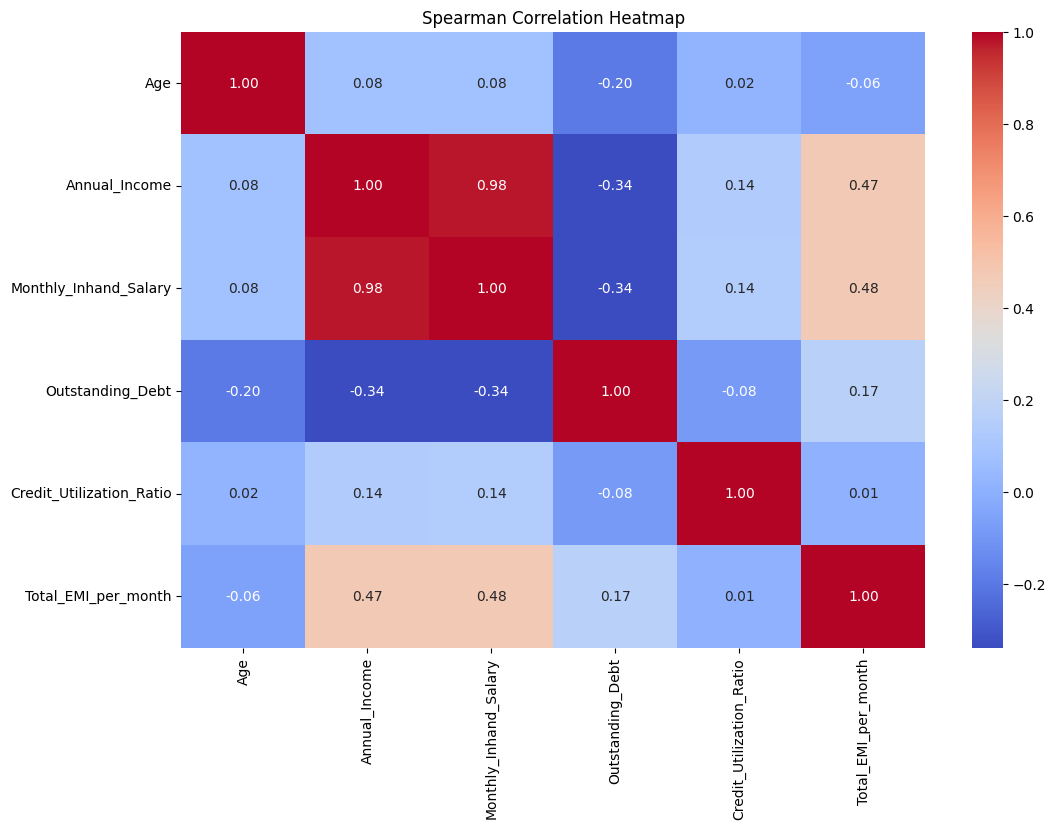

In [7]:
#EDA
#4. Correlation Analysis (Numeric Only)
plt.figure(figsize=(12,8))
corr = df[num_features].corr(method="spearman")
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()


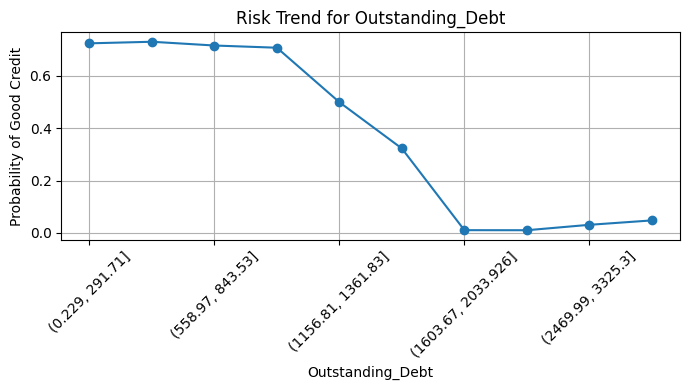

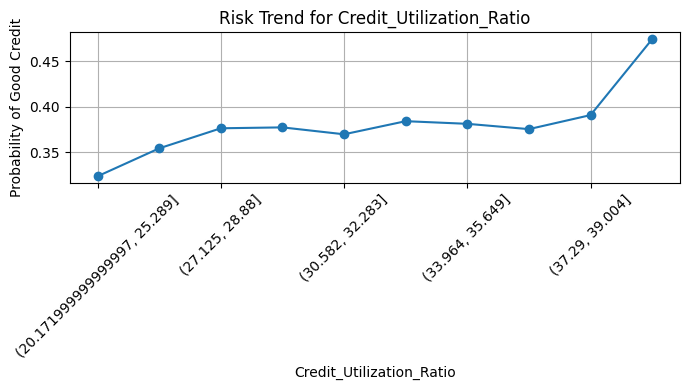

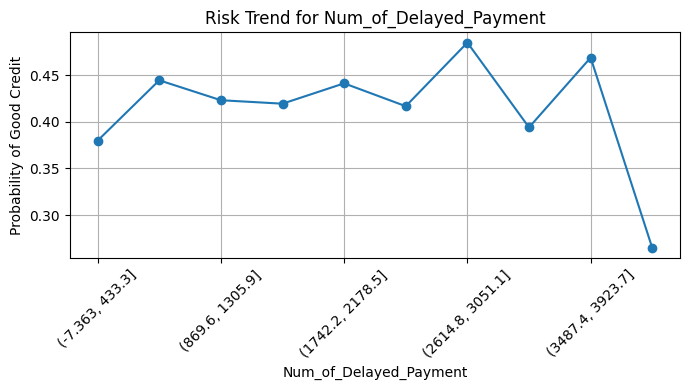

In [8]:
#EDDA

# Outstanding_Debt
temp = df[["Outstanding_Debt", "target"]].copy()
temp = temp.dropna()

temp["bin"] = pd.qcut(temp["Outstanding_Debt"], q=10, duplicates="drop")
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Outstanding_Debt")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Outstanding_Debt")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Credit_Utilization_Ratio
temp = df[["Credit_Utilization_Ratio", "target"]].copy()
temp = temp.dropna()

temp["bin"] = pd.qcut(temp["Credit_Utilization_Ratio"], q=10, duplicates="drop")
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Credit_Utilization_Ratio")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Credit_Utilization_Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Num_of_Delayed_Payment
temp = df[["Num_of_Delayed_Payment", "target"]].copy()

temp["_x"] = (
    temp["Num_of_Delayed_Payment"]
        .astype(str)
        .str.replace("+", "", regex=False)
        .replace(["NA", "nan", "None"], np.nan)
)

temp["_x"] = pd.to_numeric(temp["_x"], errors="coerce")
temp = temp.dropna(subset=["_x", "target"])

# Discrete variable → use cut, not qcut
temp["bin"] = pd.cut(temp["_x"], bins=10)
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Num_of_Delayed_Payment")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Num_of_Delayed_Payment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


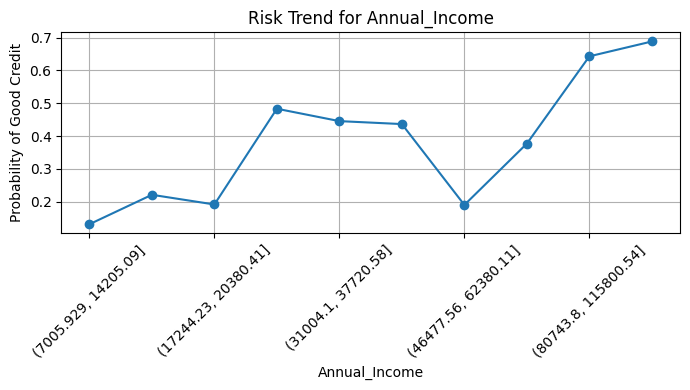

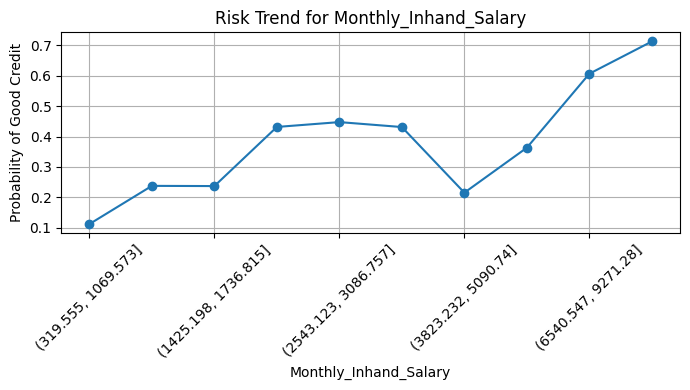

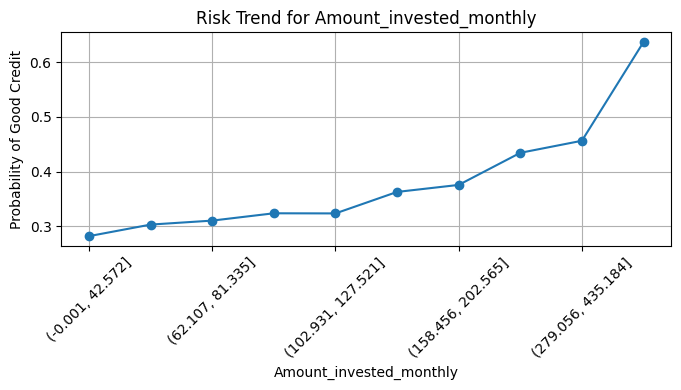

In [9]:
# EDDA for Positive Monotone Constraint Features

# Annual_Income
temp = df[["Annual_Income", "target"]].copy()
temp = temp.dropna()

temp["bin"] = pd.qcut(temp["Annual_Income"], q=10, duplicates="drop")
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Annual_Income")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Annual_Income")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly_Inhand_Salary
temp = df[["Monthly_Inhand_Salary", "target"]].copy()
temp = temp.dropna()

temp["bin"] = pd.qcut(temp["Monthly_Inhand_Salary"], q=10, duplicates="drop")
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Monthly_Inhand_Salary")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Monthly_Inhand_Salary")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Amount_invested_monthly
temp = df[["Amount_invested_monthly", "target"]].copy()
temp = temp.dropna()

temp["bin"] = pd.qcut(temp["Amount_invested_monthly"], q=10, duplicates="drop")
risk = temp.groupby("bin")["target"].mean()

plt.figure(figsize=(7,4))
risk.plot(marker="o")
plt.title("Risk Trend for Amount_invested_monthly")
plt.ylabel("Probability of Good Credit")
plt.xlabel("Amount_invested_monthly")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Comprehensive correlation test for ALL monotone constraint features
from scipy.stats import spearmanr

all_mono_features = [
    "Outstanding_Debt",
    "Num_of_Delayed_Payment",
    "Interest_Rate",
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Amount_invested_monthly"
]

print("\nMONOTONE CONSTRAINT JUSTIFICATION\n")

for col in all_mono_features:
    x = df[col]

    if not pd.api.types.is_numeric_dtype(x):
        x = (
            x.astype(str)
             .str.replace("+", "", regex=False)
             .replace(["NA", "nan", "None"], np.nan)
        )
        x = pd.to_numeric(x, errors="coerce")

    y = df["target"]
    mask = x.notna() & y.notna()
    corr, p = spearmanr(x[mask], y[mask])

    print(f"{col:30s} Spearman r={corr:+.3f}, p-value={p:.5f}")


MONOTONE CONSTRAINT JUSTIFICATION

Outstanding_Debt               Spearman r=-0.603, p-value=0.00000
Num_of_Delayed_Payment         Spearman r=-0.505, p-value=0.00000
Interest_Rate                  Spearman r=-0.594, p-value=0.00000
Annual_Income                  Spearman r=+0.291, p-value=0.00000
Monthly_Inhand_Salary          Spearman r=+0.290, p-value=0.00000
Amount_invested_monthly        Spearman r=+0.185, p-value=0.00000


In [11]:
#categorical encoding
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#handle missing numeric values
df = df.fillna(df.median(numeric_only=True))

C:\Users\anant\AppData\Local\Temp\ipykernel_30484\3469416130.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include="object").columns


In [12]:
#Train-test split
X = df.drop(columns=["target"])
y = df["target"]

print(list(X.columns))


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']


In [13]:
monotonic_constraints = []

for col in X.columns:
    if col in [
        "Outstanding_Debt",
        "Num_of_Delayed_Payment",
        "Interest_Rate"
    ]:
        monotonic_constraints.append(-1)

    elif col in [
        "Monthly_Inhand_Salary",
        "Annual_Income",
        "Amount_invested_monthly"
    ]:
        monotonic_constraints.append(+1)

    else:
        monotonic_constraints.append(0)


In [33]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import numpy as np


def evaluate_model(model, X_test, y_test, name):
    
    proba = model.predict_proba(X_test)[:,1]

    # Threshold tuning
    best_t = 0.5
    best_f1 = 0

    for t in np.arange(0.3, 0.7, 0.01):
        preds = (proba >= t).astype(int)
        f1 = f1_score(y_test, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    final_preds = (proba >= best_t).astype(int)

    print(f"\n{name}")
    print("Best Threshold:", round(best_t,2))
    print("Accuracy :", round(accuracy_score(y_test, final_preds),4))
    print("Precision:", round(precision_score(y_test, final_preds),4))
    print("Recall   :", round(recall_score(y_test, final_preds),4))
    print("F1 Score :", round(f1_score(y_test, final_preds),4))
    print("ROC-AUC  :", round(roc_auc_score(y_test, proba),4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, final_preds))

    return proba, final_preds, best_t


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

param_log = {
    "C": [0.01, 0.1, 1, 5, 10],
    "solver": ["lbfgs", "liblinear"]
}

log = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

log_search = RandomizedSearchCV(
    log,
    param_log,
    n_iter=6,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

log_search.fit(X_train, y_train)

best_log = log_search.best_estimator_

print("Best Logistic Params:", log_search.best_params_)

log_proba, log_preds, log_t = evaluate_model(
    best_log, X_test, y_test, "Logistic Regression (Tuned)"
)
log_results = {
    "Model": "Logistic Regression (Tuned)",
    "Threshold": round(log_t, 2),
    "Accuracy": round(accuracy_score(y_test, log_preds), 4),
    "Precision": round(precision_score(y_test, log_preds), 4),
    "Recall": round(recall_score(y_test, log_preds), 4),
    "F1-Score": round(f1_score(y_test, log_preds), 4),
    "ROC-AUC": round(roc_auc_score(y_test, log_proba), 4)
}


Best Logistic Params: {'solver': 'liblinear', 'C': 0.01}

Logistic Regression (Tuned)
Best Threshold: 0.53
Accuracy : 0.8374
Precision: 0.7422
Recall   : 0.8777
F1 Score : 0.8043
ROC-AUC  : 0.8996
Confusion Matrix:
[[4713 1087]
 [ 436 3130]]


In [39]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {
    "n_estimators": [150, 250],
    "max_depth": [8, 12, None],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 5]
}

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_search = RandomizedSearchCV(
    rf,
    param_rf,
    n_iter=6,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_

print("Best RF Params:", rf_search.best_params_)

rf_proba, rf_preds, rf_t = evaluate_model(
    best_rf, X_test, y_test, "Random Forest (Tuned)"
)
rf_results = {
    "Model": "Random Forest (Tuned)",
    "Threshold": round(rf_t, 2),
    "Accuracy": round(accuracy_score(y_test, rf_preds), 4),
    "Precision": round(precision_score(y_test, rf_preds), 4),
    "Recall": round(recall_score(y_test, rf_preds), 4),
    "F1-Score": round(f1_score(y_test, rf_preds), 4),
    "ROC-AUC": round(roc_auc_score(y_test, rf_proba), 4)
}



Best RF Params: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}

Random Forest (Tuned)
Best Threshold: 0.62
Accuracy : 0.9435
Precision: 0.941
Recall   : 0.9086
F1 Score : 0.9245
ROC-AUC  : 0.9866
Confusion Matrix:
[[5597  203]
 [ 326 3240]]


In [40]:
#LightGBM with hyperparameter tuning and monotonic constraints
import lightgbm as lgb

param_lgb = {
    "num_leaves": [15, 31, 63],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 300],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}

lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    monotone_constraints=monotonic_constraints,
    random_state=42
)

lgb_search = RandomizedSearchCV(
    lgbm,
    param_lgb,
    n_iter=8,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

lgb_search.fit(X_train, y_train)

best_lgb = lgb_search.best_estimator_

print("Best LGB Params:", lgb_search.best_params_)

lgb_proba, lgb_preds, lgb_t = evaluate_model(
    best_lgb, X_test, y_test, "LightGBM (Monotonic constrains and hyper parameter Tuned)"
)

lgb_mono_results = {
    "Model": "LightGBM (Tuned + Mono)",
    "Threshold": round(lgb_t, 2),
    "Accuracy": round(accuracy_score(y_test, lgb_preds), 4),
    "Precision": round(precision_score(y_test, lgb_preds), 4),
    "Recall": round(recall_score(y_test, lgb_preds), 4),
    "F1-Score": round(f1_score(y_test, lgb_preds), 4),
    "ROC-AUC": round(roc_auc_score(y_test, lgb_proba), 4)
}



[LightGBM] [Info] Number of positive: 14262, number of negative: 23198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3896
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

param_lgb_no_mono = {
    "num_leaves": [15, 31, 63],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 300],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}


lgb_no_mono = lgb.LGBMClassifier(
    class_weight="balanced",
    random_state=42,
    force_col_wise=True,
    verbose=-1
)


lgb_no_mono_search = RandomizedSearchCV(
    lgb_no_mono,
    param_lgb_no_mono,
    n_iter=8,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

lgb_no_mono_search.fit(X_train, y_train)


best_lgb_no_mono = lgb_no_mono_search.best_estimator_

print("Best LGB (No Mono) Params:")
print(lgb_no_mono_search.best_params_)



lgb_nm_proba, lgb_nm_preds, lgb_nm_t = evaluate_model(
    best_lgb_no_mono,
    X_test,
    y_test,
    "LightGBM (No Monotonic Constraints but hyper parameter tuned)"
)
lgb_nm_results = {
    "Model": "LightGBM (Tuned No-Mono)",
    "Threshold": round(lgb_nm_t, 2),
    "Accuracy": round(accuracy_score(y_test, lgb_nm_preds), 4),
    "Precision": round(precision_score(y_test, lgb_nm_preds), 4),
    "Recall": round(recall_score(y_test, lgb_nm_preds), 4),
    "F1-Score": round(f1_score(y_test, lgb_nm_preds), 4),
    "ROC-AUC": round(roc_auc_score(y_test, lgb_nm_proba), 4)
}


Best LGB (No Mono) Params:
{'subsample': 0.8, 'num_leaves': 63, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

LightGBM (No Monotonic Constraints but hyper parameter tuned)
Best Threshold: 0.64
Accuracy : 0.9439
Precision: 0.9246
Recall   : 0.9285
F1 Score : 0.9265
ROC-AUC  : 0.9869
Confusion Matrix:
[[5530  270]
 [ 255 3311]]


In [50]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


rf_probs = best_rf.predict_proba(X_test)[:, 1]
lgb_probs = best_lgb_no_mono.predict_proba(X_test)[:, 1]

ensemble_probs = (rf_probs + lgb_probs) / 2

precision, recall, thresholds = precision_recall_curve(
    y_test, ensemble_probs
)

f1_scores = 2 * precision * recall / (precision + recall + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]


ensemble_preds = (ensemble_probs >= best_threshold).astype(int)


acc = accuracy_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
auc = roc_auc_score(y_test, ensemble_probs)
cm = confusion_matrix(y_test, ensemble_preds)



print("\nRF + LightGBM (No-Mono) Ensemble")

print("Best Threshold :", round(best_threshold, 3))
print("Accuracy       :", round(acc, 4))
print("Precision      :", round(prec, 4))
print("Recall         :", round(rec, 4))
print("F1 Score       :", round(f1, 4))
print("ROC-AUC        :", round(auc, 4))

print("Confusion Matrix:")
print(cm)

ensemble_results = {
    "Model": "Ensemble (RF + LGBM No-Mono)",
    "Threshold": round(best_threshold, 3),
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1-Score": round(f1, 4),
    "ROC-AUC": round(auc, 4)
}




RF + LightGBM (No-Mono) Ensemble
Best Threshold : 0.623
Accuracy       : 0.9473
Precision      : 0.9327
Recall         : 0.9285
F1 Score       : 0.9306
ROC-AUC        : 0.9884
Confusion Matrix:
[[5561  239]
 [ 255 3311]]


In [51]:
import pandas as pd


results_table = pd.DataFrame([
    log_results,
    rf_results,
    lgb_mono_results,
    lgb_nm_results,
    ensemble_results
])

results_table


,Model,Threshold,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression (Tuned),0.530,0.8374,0.7422,0.8777,0.8043,0.8996
1,Random Forest (Tuned),0.620,0.9435,0.9410,0.9086,0.9245,0.9866
2,LightGBM (Tuned + Mono),0.530,0.9214,0.8651,0.9403,0.9011,0.9776
3,LightGBM (Tuned No-Mono),0.640,0.9439,0.9246,0.9285,0.9265,0.9869
4,Ensemble (RF + LGBM No-Mono),0.623,0.9473,0.9327,0.9285,0.9306,0.9884


In [55]:
#Statistical Test
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np


def mcnemar_test(y_true, pred1, pred2, name1, name2):

    c1 = (pred1 == y_true)
    c2 = (pred2 == y_true)

    table = np.array([
        [np.sum(c1 & c2),  np.sum(c1 & ~c2)],
        [np.sum(~c1 & c2), np.sum(~c1 & ~c2)]
    ])

    result = mcnemar(table, exact=True)

    print(f"\n{name1} vs {name2}")
    print("Table:\n", table)
    print("p-value:", result.pvalue)



mcnemar_test(
    y_test,
    ensemble_preds,
    rf_preds,
    "Ensemble",
    "Random Forest"
)

mcnemar_test(
    y_test,
    ensemble_preds,
    lgb_nm_preds,
    "Ensemble",
    "LGBM No-Monotonic Constraints"
)




Ensemble vs Random Forest
Table:
 [[8747  125]
 [  90  404]]
p-value: 0.020192757968287223

Ensemble vs LGBM No-Monotonic Constraints
Table:
 [[8783   89]
 [  58  436]]
p-value: 0.013077697334512186


In [57]:
#No overfit proof
# Train probabilities
rf_train = best_rf.predict_proba(X_train)[:,1]
lgb_train = best_lgb_no_mono.predict_proba(X_train)[:,1]

ensemble_train = (rf_train + lgb_train)/2


train_auc = roc_auc_score(y_train, ensemble_train)
test_auc = roc_auc_score(y_test, ensemble_probs)

print("Train AUC:", train_auc)
print("Test AUC :", test_auc)
print("Gap      :", train_auc - test_auc)


Train AUC: 0.999832222998929
Test AUC : 0.9884026824221093
Gap      : 0.011429540576819774


c:\Users\anant\credit_score\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


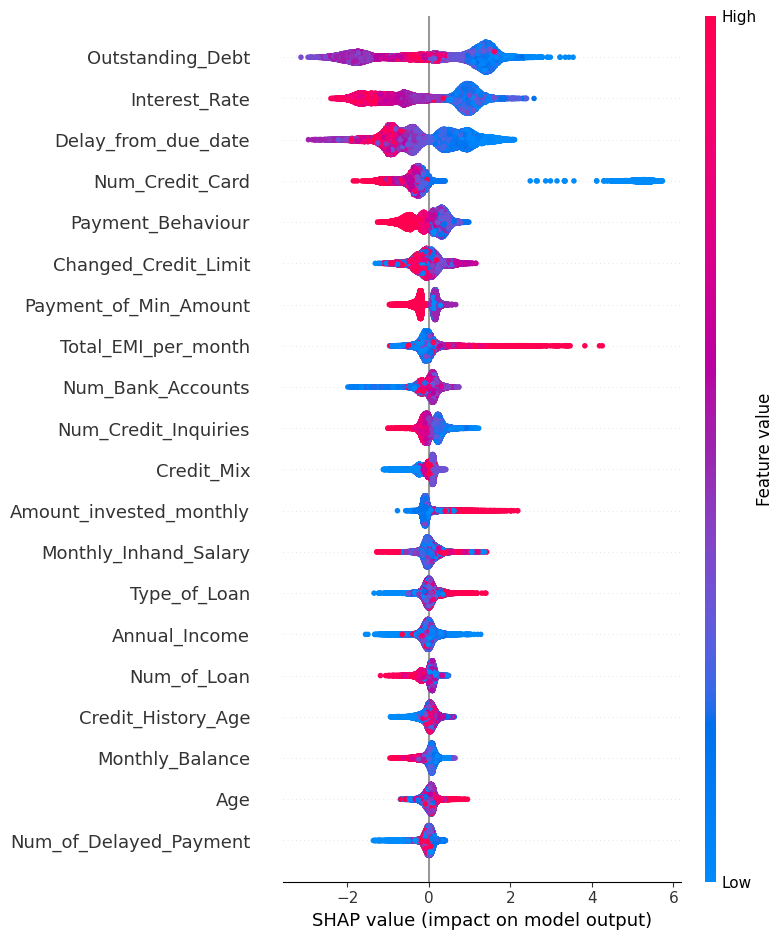

In [59]:
#feature importance for LGBM
import shap

explainer = shap.TreeExplainer(best_lgb_no_mono)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [62]:
#RF feature importance
import pandas as pd

rf_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(rf_imp.head(10))


                  Feature  Importance
14       Outstanding_Debt    0.170123
6           Interest_Rate    0.137433
9     Delay_from_due_date    0.101853
12   Num_Credit_Inquiries    0.081847
17  Payment_of_Min_Amount    0.064912
4       Num_Bank_Accounts    0.064910
7             Num_of_Loan    0.051513
5         Num_Credit_Card    0.038516
2           Annual_Income    0.028642
16     Credit_History_Age    0.028136


In [63]:
#Ensemble importance
lgb_imp = best_lgb_no_mono.feature_importances_

ens_imp = (rf_imp["Importance"].values + lgb_imp)/2

ens_imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": ens_imp
}).sort_values(by="Importance", ascending=False)

print(ens_imp_df.head(10))


                  Feature  Importance
14       Outstanding_Debt  570.510599
18    Total_EMI_per_month  503.508494
8            Type_of_Loan  470.514321
6           Interest_Rate  403.525756
3   Monthly_Inhand_Salary  402.540924
2           Annual_Income  392.550927
11   Changed_Credit_Limit  384.512445
16     Credit_History_Age  370.010193
9     Delay_from_due_date  325.014068
0                     Age  304.085061


In [64]:
#KS score for ensemble
from scipy.stats import ks_2samp

ks = ks_2samp(
    ensemble_probs[y_test==1],
    ensemble_probs[y_test==0]
)

print("KS Statistic:", ks.statistic)
print("p-value:", ks.pvalue)

KS Statistic: 0.8892991277776703
p-value: 0.0


In [68]:
auc = roc_auc_score(y_test, ensemble_probs)
gini = 2*auc - 1

print("Gini:", gini)


Gini: 0.9768053648442185


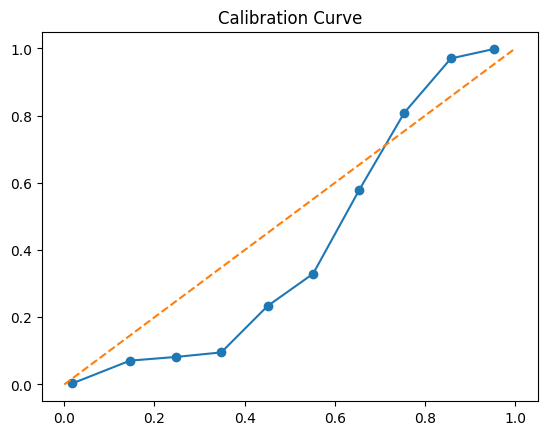

In [69]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(
    y_test, ensemble_probs, n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.title("Calibration Curve")
plt.show()


In [71]:
import joblib


# Save trained models
joblib.dump(best_rf, "rf_model_tuned.pkl")
joblib.dump(best_lgb_no_mono, "lgbm_nomono_model.pkl")


# Save ensemble weight (50-50)
ensemble_config = {
    "rf_weight": 0.5,
    "lgb_weight": 0.5
}

joblib.dump(ensemble_config, "ensemble_config.pkl")


print("Models saved successfully!")

Models saved successfully!
